To do
1. random positions
2. re-randomize after complex
3. check 3d
4. pycuda

## Mathematical Simulation in Python, Billiard Dynamical Systems
### Summer Workshop in Mathematics, University of Brasilia
### Summer 2018, Session 4, Scott Cook

Our code has become more involved as we added more complex behaviors.  The file billiard_defs_4a.py is the final version.  It adds particle-particle collisions, both specular and no-slip.  It also allows us to ignore such collisions by setting pp_collision_law='pp_ignore'.

This version also takes greater care to handle "complex" collisions where a particle hits more than one other object (wall or particle).  Currently, the code will simply terminate if such an event occurs.  Luckly, this is very rare.  A more advanced version would include a method to re-randomize the position of a particle involved in such an event (we simply did not hve time to implement that).

Let us conclude by using the code below to analyze the effect of wp_specular_law vs wp_no_slip_law on diffusion in the Lorentz gas.

Note from p.3 of Dettmanns's paper https://github.com/drscook/unb_billiards/blob/master/references/Lorentz%20gas/dettmann_2014.pdf


For specular collision law in the finite horizon case, we expect the diffusion matrix $D_{ij} = \frac{\langle \Delta_i \Delta_j \rangle}{2t}$ to converge to a multiple of the identity matrix as $t \to \infty$.  Furthermore, we expect $\frac{\Delta(t)}{\sqrt{t}} \to N(0,2D_{ij})$.  Let us test this.


On p.8, Dettmann discussed anomalous diffusion for the infinite horizon case with the specular collision law.  We expect the diffusion matrix $D_{ij} = \frac{\langle \Delta_i \Delta_j \rangle}{2t\ln t}$ to converge to a multiple of the identity matrix as $t \to \infty$.  Furthermore, we expect $\frac{\Delta(t)}{\sqrt{t \ln t}} \to N(0,D_{ij})$.  Let us test this.

Running wp_specular collision law
Done!! Steps = 100, Time = 8235.098423
Normal diffusion law


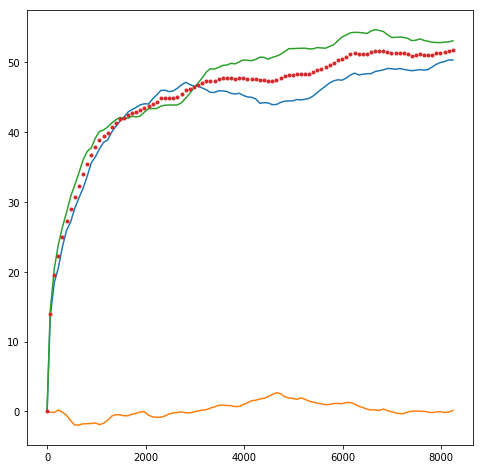

51.3222294853


A Jupyter Widget

Anomalous diffusion law


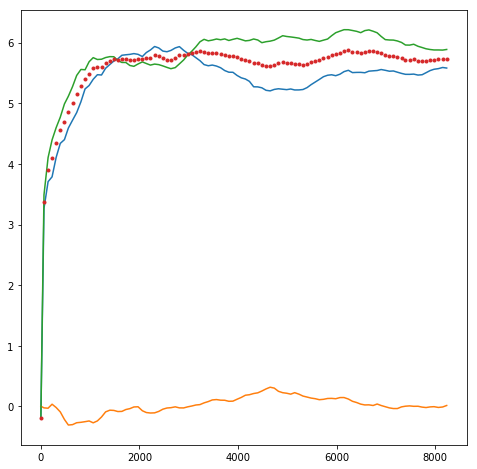

5.7777965346


billiard_defs_4a.py:67: RuntimeWarning: invalid value encountered in sqrt
  hnew = np.linspace(h.min(),h.max(),300)


A Jupyter Widget

Running wp_no_slip collision law
Done!! Steps = 100, Time = 8500.616651
Normal diffusion law


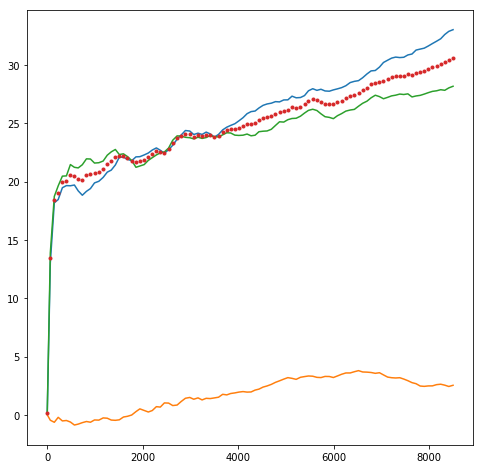

29.0806765421


A Jupyter Widget

Anomalous diffusion law


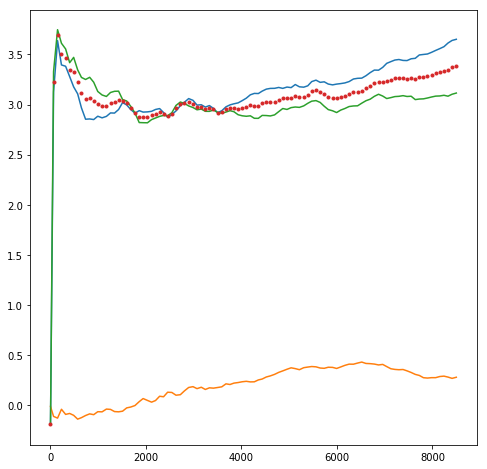

3.26138819774


A Jupyter Widget

Wall time: 4min 27s


In [6]:
%%time
%matplotlib inline
seed = 10
# Note we use version 4a now
%run -i billiard_defs_4a.py

dim = 2
R_particle = 1.0
R_scatter = 50.0
# system = 'Sinai'
system = 'Lorentz'

# wp_collision_law = 'wp_specular'
# wp_collision_law = 'wp_no_slip'

# pp_collision_law = 'pp_specular'
# pp_collision_law = 'pp_no_slip'
pp_collision_law = 'pp_ignore'

for wp_collision_law in ['wp_specular', 'wp_no_slip']:
    print('Running {} collision law'.format(wp_collision_law))
    if system == 'Lorentz':
        factor = 3.0
        R = R_particle + R_scatter
        gap_crit = (2/np.sqrt(3) - 1) * R
        gap = factor * gap_crit
        x0 = R + gap
        y0 = np.sqrt(3) * x0
        wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], gap_pad=0, wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=1)
                ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], gap_pad=0, wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=0)
                ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], gap_pad=0, wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=3)
                ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], gap_pad=0, wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=2)
                ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,SphereWall(dim=dim, base_point=[-x0, -y0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,SphereWall(dim=dim, base_point=[x0, -y0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,SphereWall(dim=dim, base_point=[-x0, y0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,SphereWall(dim=dim, base_point=[x0, y0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
               ]    
    elif system == 'Sinai':
        R = R_particle + R_scatter
        x0 = 3 * R
        y0 = x0    
        wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], gap_pad=R_particle, wp_collision_law=wp_collision_law)
                ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle, wp_collision_law=wp_collision_law)
               ]

    for (i, w) in enumerate(wall):
        w.idx = i

    part = Particles(num=800, max_steps=100000, mass=1, cell_size=[x0, y0], dim=dim, radius= R_particle
                     ,gamma='uniform' , pp_collision_law=pp_collision_law
                    )

    # init pos
    theta = rnd.uniform(0, 2*np.pi, part.num)
    part.pos = 1.01 * wall[4].wp_gap_min * np.asarray([np.cos(theta), np.sin(theta)]).T

    # init vel
    theta = rnd.uniform(0, 2*np.pi, part.num)
    speed = 1.0
    part.vel = speed * np.asarray([np.cos(theta), np.sin(theta)]).T

    # init orient
    part.orient = np.asarray([np.eye(part.dim) for p in range(part.num)]).astype(float)

    # init spin
    speed = 1.0
    m = int(part.dim*(part.dim-1)/2)
    part.spin = np.asarray([spin_matrix_from_vector([random_uniform_sphere(num=1, dim=m, radius=speed)])
                            for p in range(part.num)]).astype(float)


    approx_num_records = 100
    rec_period = np.round(part.max_steps / approx_num_records)
    # rec_period = 20

    part.KE_init = part.get_KE().sum()
    part.record_state()
    check()
    for step in range(part.max_steps):
        next_state(wall, part)
        if step % rec_period == 0:
            part.record_state()
    #     check()
    clean_up(part)
    print('Normal diffusion law')
    analyze_diffusion(anomalous=False)
    print('Anomalous diffusion law')
    analyze_diffusion(anomalous=True)

For the specular, finite horizon case, we see exactly what Dettmann promised.  For the no-slip, finite horizon, we are excited to see that the same diffusion law seems to hold.  This is a bit surprising, given how much different no-slip seemed in the parallel planes and wedges examples in session 3.  Cool - we have the beginnings of a new result!!!

The infinite horizon case is a little confusing because BOTH normalization look good.  We expected the normal diffusion to depart from the simulation results.  We believe that we have not run the simulation long enough to observe the departure.  After all, $\sqrt{\ln{t}}$ is quite small for values of $t$ that are not very large.

This brings us to speed considerations.  Python is fast to write, but can be slow to run.  There are a variety of ways to speed it up.  My favorite is PyCuda: https://mathema.tician.de/software/pycuda/.  If you have access to a GPU, PyCuda allows you to write most of your code in python (where things are easier but slow) and drop into Cuda (where things are harder but fast) for the slowest parts of your code.

I had hoped to provide a working demo using a GPU enabled machine at my home institution.  Sadly, they have had some very serious storms this week and the machine is not accessible now.  So, we will discuss PyCuda more broadly.

I'd like to thank all of you.  I have had a great time at Univ of Brasilia this week.  I hope these workshop have been helpful and propel you to even high heights as scientists and mathematicians.  Obrigado!!